The goal for running tractor is to find the ideal model of a galaxy using (a combination of) cersic, exponential, and de Vaucouleurs models. In order to do this, we need to:
- create a tractor image (which is a model of the galaxy) using the following models:
    - cersic
    - exponential
    - de Vaucouleurs
    - composites    
- take the model and compare it to the DECaLs deep imaging results of the same image

In [1]:
import os

from astrometry.util.fits import fits_table
from astrometry.util.util import wcs_pv2sip_hdr

import fitsio
import numpy as np
import pylab as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import sep
import tractor

from tractor import NullWCS
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

In [2]:
#open fits files
num = '26'
galaxy_dir = os.path.dirname(os.path.abspath(num+'_tractor_ready'))
path = os.path.join(galaxy_dir,num+'_tractor_ready')

img_data = fits.open(os.path.join(path,'img_data_crop_'+num+'.fits'))[0].data
psf_data = fits.open(os.path.join(path,'psf_data_crop_'+num+'.fits'))[0].data
psf_obj = tractor.PixelizedPSF(psf_data, Lorder=5)
sig_data = fits.open(os.path.join(path,'sig_data_crop_'+num+'.fits'))[0].data
#bad_data = fits.open(path+'bad.fits')[0].data

obj_cat = Table.read(path+'/tractor_'+num+'.fits')

invvar_data = (1.0 / (sig_data ** 2.0))

w = NullWCS(pixscale=0.168)

In [3]:
tim = tractor.Image(data=img_data,
            invvar=invvar_data,
            psf=psf_obj,
            wcs=w,
            sky=tractor.ConstantSky(0.0),
            photocal=tractor.NullPhotoCal()
            )

In [4]:
sources=[]

for obj in obj_cat:
    # if the object is a point source, add it as such
    if obj['point_source'] > 0.0:
        sources.append(tractor.PointSource(tractor.PixPos(obj['x'], obj['y']),
                                           tractor.Flux(obj['flux'])) )
    else:
        sources.append(tractor.DevGalaxy(tractor.PixPos(obj['x'], obj['y']),
                                         tractor.Flux(obj['flux']),
                                         GalaxyShape(obj['a'] / 2.0, 
                                                     (obj['b'] / obj['a']),
                                                     (180.0 - obj['theta'] * 180.0 / np.pi))))

In [5]:
print(len(sources))

57


In [6]:
trac_obj = Tractor([tim], sources)
trac_mod = trac_obj.getModelImage(0, minsb=0., srcs=sources)

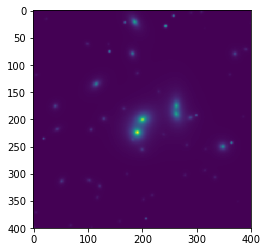

In [7]:
plt.imshow(np.arcsinh(trac_mod))
plt.show()

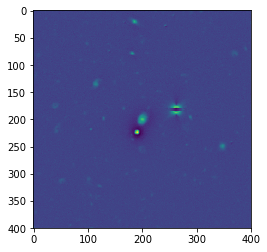

In [8]:
plt.imshow(np.arcsinh(img_data - trac_mod))
plt.show()

In [ ]:
trac_obj.freezeParam('images')

In [ ]:
trac_obj.optimize_loop()

In [ ]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(trac_mod_opt))
plt.show()

In [ ]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(img_data - trac_mod_opt))
plt.show()

In [ ]:
plt.imshow(np.arcsinh(img_data))
plt.show()
